In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

In [9]:
df = pd.read_csv('./Data/PJME_hourly.csv')
df = df.set_index('Thời gian')
df['Thời gian'] = pd.to_datetime(df['Thời gian'])

df_sorted = df.sort_values(by='Thời gian')
df_sorted.reset_index(drop=True, inplace=True)
df_sorted['Thời gian'] = pd.to_datetime(df_sorted['Thời gian'].astype('int64'))

df_sorted.to_csv('./Data/Sorted_PJME_hourly.csv', index=False)

df = df_sorted
print(df)

KeyError: 'Thời gian'

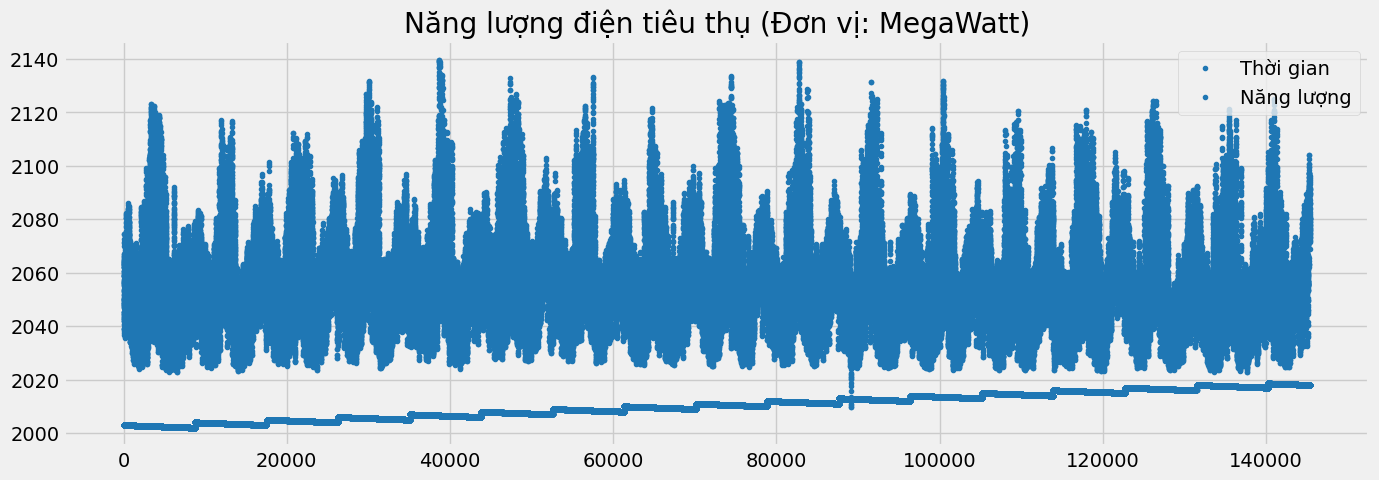

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Năng lượng điện tiêu thụ (Đơn vị: MegaWatt)')

plt.show()

## Train / Test Split

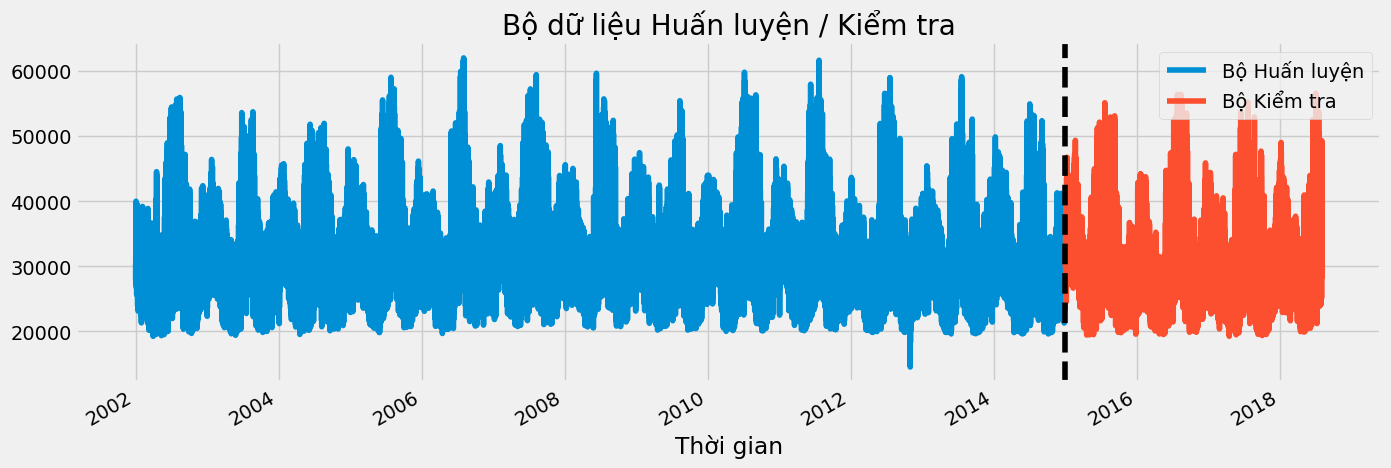

In [14]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Bộ Huấn luyện', title='Bộ dữ liệu Huấn luyện / Kiểm tra')
test.plot(ax=ax, label='Bộ Kiểm tra')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Bộ Huấn luyện', 'Bộ Kiểm tra'])
plt.show()

In [40]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Dữ liệu theo Tuần')

df_week = df.loc['2010-01-01':'2010-01-08']
df_week.to_csv('Data/WeekData.csv')

plt.show()

TypeError: Invalid comparison between dtype=int64 and str

## Feature Creation

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

## Create our Model

In [7]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Năng lượng'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [8]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


c:\Users\trucn\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

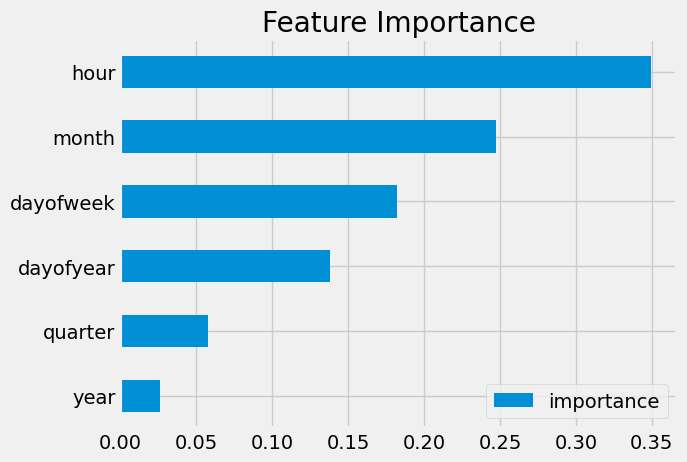

In [9]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

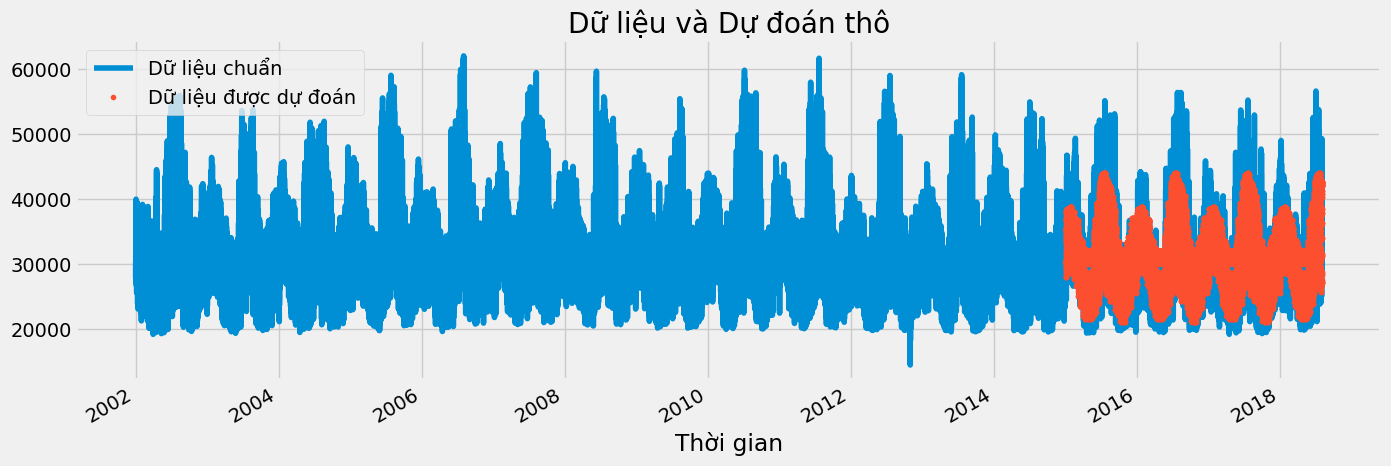

In [10]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)
ax = df[['Năng lượng']].plot(figsize=(15, 5))
df['prediction'].plot(ax = ax, style='.')
plt.legend(['Dữ liệu chuẩn', 'Dữ liệu được dự đoán'])
ax.set_title('Dữ liệu và Dự đoán thô')
plt.show()

In [11]:
df_prediction = df['prediction'].loc[df.index >= '01-01-2015']

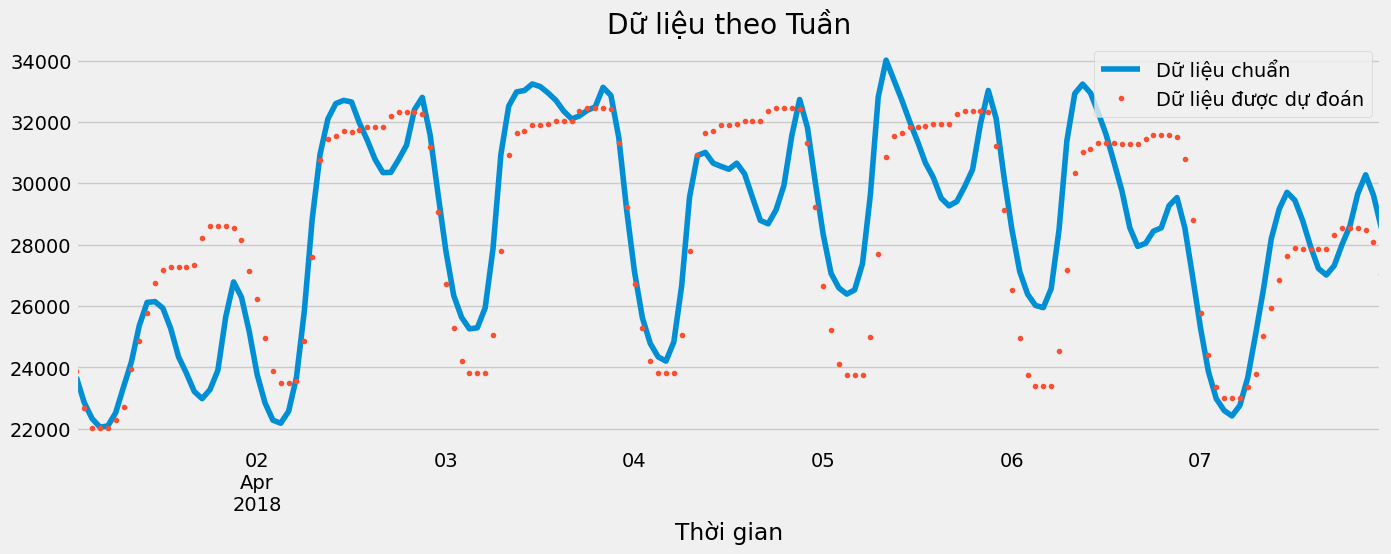

In [12]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['Năng lượng'] \
    .plot(figsize=(15, 5), title='Dữ liệu theo Tuần')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Dữ liệu chuẩn','Dữ liệu được dự đoán'])
plt.show()